<h4> Importing Libraries </h4>

In [45]:
import sys
import os 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
from random import random, randrange, betavariate
from numpy.random import uniform, choice
import math

<h1> Simulation Functions </h1>

In [46]:
def generate_bernouilli_variables(number_of_arms):
    bernoulli_variables = np.random.dirichlet(np.ones(number_of_arms), size=1)
    return bernoulli_variables[0]


def simulate_bernouilli_experience(conversion_rate):
    if np.random.rand() < conversion_rate:
        return 1
    else:
        return 0


def simulate_bernouilli_round(conversion_rates):
    simulated_round_data = [
        simulate_bernouilli_experience(conversion_rate)
        for conversion_rate in conversion_rates
    ]
    return simulated_round_data


def generate_bernoulli_simulation(number_of_rounds, conversion_rates):

    rounds_array = np.array(
        [simulate_bernouilli_round(conversion_rates) for i in range(number_of_rounds)]
    )

    bernouilli_simulation = pd.DataFrame(
        {"Arm " + str(i): rounds_array[:, i] for i in range(len(conversion_rates))}
    )
    return bernouilli_simulation

<h1> Bandit Algorithm Functions </h1>

In [3]:
def get_exploration_selected_strategies(rounds_array, number_exploration_rounds):

    exploration_selected_strategies = [
        randrange(rounds_array.shape[1]) for episode in range(number_exploration_rounds)
    ]

    return exploration_selected_strategies


def get_exploration_rewards(rounds_array, exploration_selected_strategies):

    exploration_rewards = [
        rounds_array[current_round, selected_arm]
        for (current_round, selected_arm) in zip(
            range(len(rounds_array)), exploration_selected_strategies
        )
    ]

    return exploration_rewards


def get_best_arm_after_exploration(
    exploration_selected_strategies, exploration_rewards
):

    exploration_summary = pd.DataFrame(
        {"Selected Arm": exploration_selected_strategies, "Reward": exploration_rewards}
    )

    total_rewards_per_arm = exploration_summary.groupby("Selected Arm")["Reward"].max()

    best_arm_post_exploration = total_rewards_per_arm.idxmax()

    return best_arm_post_exploration


def get_exploitation_rewards(
    rounds_array, arm_for_exploitation, number_exploration_rounds
):

    exploitation_rewards = [
        rounds_array[current_round, arm_for_exploitation]
        for current_round in range(number_exploration_rounds, len(rounds_array))
    ]

    return exploitation_rewards


def explore_then_commit(rounds_array, number_exploration_rounds):

    exploration_selected_strategies = get_exploration_selected_strategies(
        rounds_array, number_exploration_rounds
    )

    exploration_rewards = get_exploration_rewards(
        rounds_array, exploration_selected_strategies
    )

    arm_for_exploitation = get_best_arm_after_exploration(
        exploration_selected_strategies, exploration_rewards
    )

    exploitation_rewards = get_exploitation_rewards(
        rounds_array, arm_for_exploitation, number_exploration_rounds
    )

    rewards = exploration_rewards.copy()

    rewards.extend(exploitation_rewards)

    selected_arms = exploration_selected_strategies.copy()

    selected_arms.extend(
        [arm_for_exploitation for i in range(len(rewards) - len(exploration_rewards))]
    )

    return rewards, selected_arms

<h1> Processing & Regret Analysis Functions </h1>

In [4]:
def compute_strategy_regret(number_of_rounds, selected_arms, arm_means):
    means_per_round = [arm_means[selected_arm] for selected_arm in selected_arms]

    regret = number_of_rounds * max(arm_means)
    regret = regret - sum(means_per_round)

    return regret


def compute_instance_worst_possible_regret(number_rounds, arm_means):
    worst_arm_index = arm_means.index(min(arm_means))

    worst_possible_selections = [worst_arm_index for i in range(number_rounds)]

    worst_possible_regret = compute_strategy_regret(
        number_rounds, worst_possible_selections, arm_means
    )

    return worst_possible_regret


def compute_immediate_regrets(rewards, best_arm_mean):
    try:
        flattened_rewards = [reward for sublist in rewards for reward in sublist]
    except:
        flattened_rewards = rewards.copy()
    immediate_regrets = []
    for i in range(len(flattened_rewards)):
        current_empirical_mean = np.mean(flattened_rewards[: i + 1])
        immediate_regrets.append(best_arm_mean - current_empirical_mean)
    return immediate_regrets


def plot_immediate_regrets(list_of_immediate_regrets, labels):
    plt.figure(figsize=(15, 10))
    for i in range(len(list_of_immediate_regrets)):
        plt.plot(list_of_immediate_regrets[i], label=labels[i])
    plt.legend()
    plt.xlabel("Number of rounds")
    plt.ylabel("Regret")


def plot_arm_selection_histogram(selected_arms):
    plt.figure(figsize=(13, 9))
    plt.hist(selected_arms)
    plt.xlabel("Arms")
    plt.ylabel("Number of Selections")


################# UCB Specific Functions #####################


def plot_upper_confidence_bounds_decrease(upper_confidence_bounds, figsize=(17, 15)):

    plt.figure(figsize=figsize)
    for i in range(upper_confidence_bounds.shape[0]):
        plt.plot(upper_confidence_bounds[i][1:], label="Arm {}".format(i))
    plt.legend(prop={"size": 17})
    plt.xlabel("Number of Selections")
    plt.ylabel("Upper Confidence Bound")


def plot_regret_versus_UCB_probability_error(
    dataset, selected_arms, probability_errors=np.linspace(0.001, 1, 30)
):

    all_ucb_rewards = []
    all_ucb_selected_arms = []

    for probability_error in probability_errors:
        ucb_rewards, ucb_selected_arms, upper_confidence_bounds = UCB_sub_gaussian(
            dataset.values, probability_error
        )
        all_ucb_rewards.append(ucb_rewards)
        all_ucb_selected_arms.append(ucb_selected_arms)

    regrets_in_function_of_error = pd.Series(
        data=[
            compute_strategy_regret(len(dataset), ucb_selected_arms, selected_arms)
            for ucb_selected_arms in all_ucb_selected_arms
        ],
        index=probability_errors,
    )

    plt.figure(figsize=(9, 9))
    regrets_in_function_of_error.plot()
    plt.xlabel("Error Probability")
    plt.ylabel("Regret")


##################### Thompson Sampling Specific Functions #####################


def plot_posteriors(beta_priors, ax=None, title=None):
    # fig = plt.figure(figsize=(12.5, 10))

    x = np.linspace(0.001, 1, 150)
    for i, (alpha, beta) in enumerate(beta_priors):
        # color = assets[i]
        y = stats.beta.rvs(alpha, beta, size=10000)
        """
        lines = sns.lineplot(
            x, y, label="%s (%.1f,%.1f)" % (color, alpha, beta), color=color, ax=ax
        )
        """
        lines = sns.lineplot(x, y, label="(%.1f,%.1f)" % (alpha, beta), ax=ax)
        # lines = sns.distplot(y)
        # plt.fill_between(x, 0, y, alpha=0.2, color=color)
        if title:
            plt.title(title)
        plt.autoscale(tight=True)
    plt.legend(title=r"$\alpha, \beta$ - beta_priors")
    return plt



def plot_thompson_samping_beta_parameters_evolution():
    fig = plt.figure(figsize=(40, 60))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    cnt = 1
    for i in range(0, 30, 2):
        ax = fig.add_subplot(8, 4, cnt)
        g = plot_posteriors(*data[i][1:], ax, "after " + str(i) + " runs")
        cnt += 1
    plt.show()


<h1> Strategy 1 : Explore then Commit - AB Testing  </h1>

AB Testing is the most commonly used statistical method by websites or advertising teams whenever they want to roll out feature and test it's efficiency using many different versions of the feature.

In AB Testing, we usually start with a Control Group (for example, an older version of the ad) and a Test Group (the latest version of the ad). Then, we give ourselves a certain number of trial rounds. During these trial rounds, we choose each group the same number of times.

This is equivalent to a <b> 2-Armed-Bandit </b> setting with a strategy called <b> Uniform Exploration </b> or <b> Explore then Commit (ETC) </b>: explore arms uniformly for $M$ rounds each, regardless of what has been observed previously ($2M$ rounds total for exploration), then pick the empirically best arm for exploitation during the $N - 2M$ left rounds.

In [47]:
number_of_rounds = 10000

We will be simulating the Bernoulli experiments to generate the data for this study :
* Ad A Conversion Rate : 0.15
* Ad B Conversion Rate : 0.22

In [48]:
ads_click_through_rates = [0.15, 0.23]

In [49]:
dataset = generate_bernoulli_simulation(number_of_rounds, ads_click_through_rates)

In [50]:
dataset.head(10)

,Arm 0,Arm 1
0,0,0
1,0,0
2,0,1
3,0,0
4,0,0
5,0,1
6,1,0
7,0,0
8,0,1
9,0,0


<h3> Running the AB Test </h3>

In [51]:
rewards_per_arm, selected_arms = explore_then_commit(dataset.values, number_exploration_rounds= 1000)

<h3> What's the worst AB Testing can do ? </h3>

We can run the code as many times as we like, but once thing is certain, if we prove an upper bound on the expected regret, it guarantees a correctly implemented strategy never diverges  

We will give the upper bound directly : $E(R(N)) \leq M K + O(N\sqrt\frac{log(N)}{M})$

The first term represents the <b> exploration </b> phase's contribution to the regret while the second term represents <b> exploitation </b> : Keeping $M$ small makes the second term high, this makes senses since spending little time exploring increases our chances of commiting to the wrong arm. On the other hand, increasing $M$ decreases that risk, but increases the first term's contribution to the regret : <b> it's the exploration-exploitation tradeoff </b> 

Theory tells us that M is optimal when we set $M$ such that the two terms are (approximately) equal. This value is$M = (\frac{N}{K})^{\frac{2}{3}}(log (N))^{\frac{1}{3}}$ 

We obtain the best Regret Upper Bound for the ETC Strategy : <b> $ E(R(N)) \leq N^{\frac{2}{3}}O(Klog(N))^{\frac{1}{3}}$ </b>

The UCB Algorithm's Upper Bound is : <b> $ E(R(N)) \leq O(\sqrt{KNlog(N)})$ </b>

For $K=2$, we plot the two Upper Bounds by using a range of values of $N$, then we compare the worst case performance of ETC and UCB.

In [10]:
def etc_bound(N, K):
    res = K*np.log(N)
    res = res**(1/3)
    res = res*(N**(2/3))
    return res

In [11]:
def ucb_bound(N, K, t):
    res = t*K*np.log(N)
    res = np.sqrt(res)
    return res

In [52]:
etc_data = [etc_bound(N,2) for N in range(2, 100000)] 
ucb_data = [ucb_bound(N,2, N) for N in range(2, 100000)]

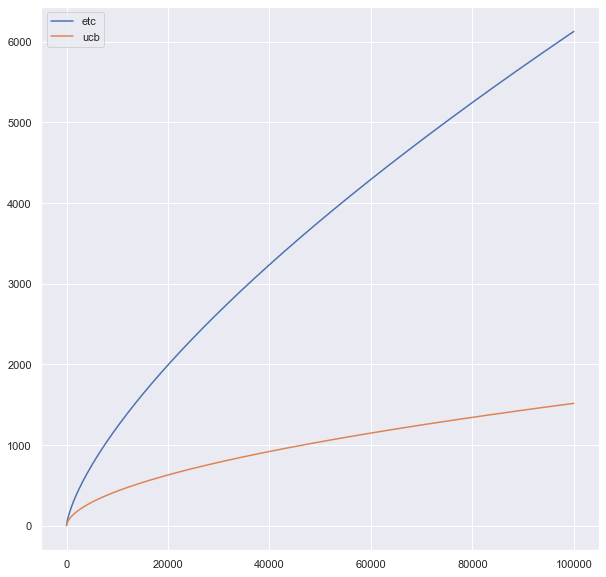

In [53]:
sns.set()
plt.figure(figsize=(10,10))
plt.plot(etc_data, label = "etc")
plt.plot(ucb_data, label = "ucb")
plt.legend()

### Main limitations of an AB Test

<b> Limitation 1 : We can't know which ad is best during the AB Testing Campaign </b> 

All our results rely on the assumption that we need as many observations in the Test Group as in the Control Group, which requires us to deploy both ads to real users a sufficient number of times just to decide which one should be kept as the final ad to use.

And we need to do this each time we have a new feature/ad to roll out.

In a nutshell, <b> we can't identify which ad is the best until we have wasted a signigicant amount of impressions </b> 

For websites with a lot of traffic, this may not be a problem, but a start up with a limited amount of funds to buy impressions on the web can't afford to allocate enough ressources for this kind of testing

<b> We need to be able to learn on the fly which ad is the best to deploy </b>

<b> Limitation 2 : What if we need to test many new features at once ? </b>

We may also not have the time or ressources to do an AB Test for every important feature we need to roll out, and if we want to roll out many features at once, it would be even more ressource-intensive define many test groups and track the added value simultaneously

In the example below, we would like to quickly identify in a statisticaly significant manner which ad is the best, the AB test is not a convenient enough solution

<h1> Strategy 2 : $\epsilon$-greedy </h1>

A clear take-away from Strategy 1 is that exploration should not be concentrated at the beginining, it should be spread out over the $N$ rounds. This avoids the risk of completely focusing on the wrong arm from the beginning.

From now on, we can also choose to work with $K \geq 2$

<h3> Main Idea </h3>

A simple and very famous strategy that spreads out exploration is called $\epsilon$-greedy and works like the following : 

During all $N$ rounds :
* <b> With probability $\epsilon$ </b>: Choose the empirically best arm available
* <b> With probability $1 - \epsilon$ </b>: Choose any other arm but the empirically best one (forced exploration)

<b> Question 3: </b> Should $\epsilon$ stay constant or should it vary during execution ? In case it's the second choice, how should it vary ? <b> </b>

<b> Answer : </b>  Since at first you have little information about the arms, the concept of an "empirically best arm" doesn't make much sense, it is best to start with a low  value of $\epsilon$ to gather information and increase it as the algorithm learns. 

<h3> Coding $\epsilon$-greedy </h3>

During each round of $\epsilon$-greedy there always two steps happening :
* Identifying which arm is the best
* Use epsilon to decide if you will use the identified best arm or not

The two following functions correspond to the two main steps of each round, they are both used in the global function epsilon_greedy that runs the whole strategy 

In [54]:
def identify_current_best_arm(rewards_per_arm):
    mean_rewards_per_arm = {
        arm: np.mean(rewards) for (arm, rewards) in rewards_per_arm.items()
    }

    current_best_arm = max(mean_rewards_per_arm, key=mean_rewards_per_arm.get)

    return current_best_arm

In [55]:
def select_arm_with_epsilon_greedy_strategy(number_of_arms, epsilon, current_best_arm):
    if uniform(0, 1) < epsilon:
        selected_arm = current_best_arm
    else:
        other_arms = [arm for arm in range(number_of_arms) if arm != current_best_arm]
        selected_arm = choice(other_arms)
    return selected_arm

In [56]:
def epsilon_greedy(dataset, epsilon):

    number_of_rounds = dataset.shape[0]
    number_of_arms = dataset.shape[1]
    rewards_per_arm = {arm: [] for arm in range(number_of_arms)}
    selected_arms = []

    for episode in range(number_of_rounds):
        if episode < number_of_arms:
            ### Initialization : We have to play each arm at least once before the strategy can be implemented
            selected_arm = episode
        else:
            current_best_arm = identify_current_best_arm(rewards_per_arm)
            selected_arm = select_arm_with_epsilon_greedy_strategy(
                number_of_arms, epsilon, current_best_arm
            )

        selected_arms.append(selected_arm)
        rewards_per_arm[selected_arm].append(dataset[episode][selected_arm])

    return rewards_per_arm, selected_arms


<h3> Running $\epsilon$-greedy </h3>

In [57]:
number_of_rounds = 10000
number_of_arms = 4
click_through_rates = generate_bernouilli_variables(number_of_arms)

In [58]:
click_through_rates

array([0.11891982, 0.14188066, 0.0313415 , 0.70785802])

In [59]:
dataset = generate_bernoulli_simulation(number_of_rounds, click_through_rates)

In [60]:
rewards_per_arm, selected_arms = epsilon_greedy(dataset.values, epsilon = 0.9)

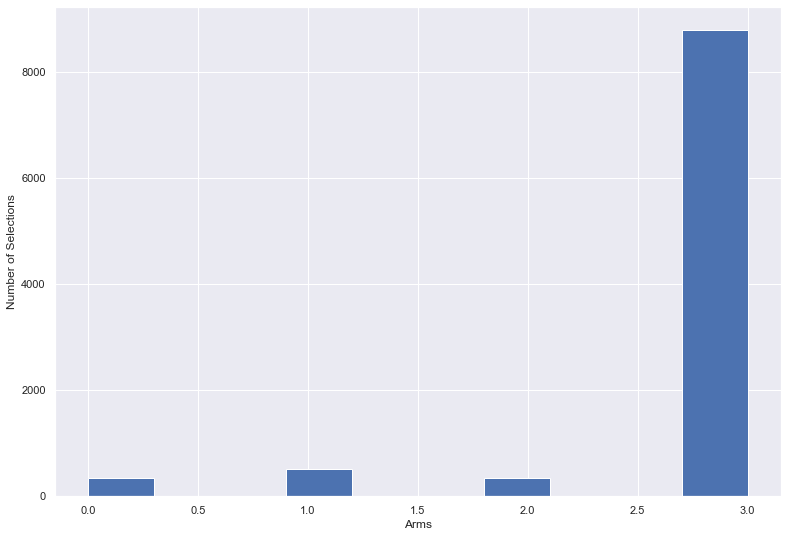

In [61]:
plot_arm_selection_histogram(selected_arms)

When $\epsilon$-greedy chooses not to use the empirically best arm, it randomly selects all other arms with a uniform probability. This means that <b> all sub-optimal arms are considered equally even if some may be more advantageous than others. </b> As a result $\epsilon$-greedy's method of exploration is too naive and can clearly be optimized by creating a ranking between sub-optimal arms which UCB undirectly does.

$\epsilon$-greedy's Expected Regret : $E(R(N)) \leq N^{\frac{2}{3}}O(Klog(N))^{\frac{1}{3}}$ (Better than Uniform Exploration since we move from an $N$ dependence to an $i$ dependence, but still less good than UCB which explored in a smarter way)

<h1> Strategy 3 : Adaptive Exploration using the UCB algorithm </h1>

<b> Setting </b>

We consider a k-armed Stochastic Bandit setting, our rewards $(r_{i})$ being a sequence of Bernoulli random variables of mean $\mu $ and empirical mean $\hat{\mu} $

We set a hyperparameter 0 < $\delta$ < 1, $T_{k}(i)$ represents the number of times we have used arm $k$ up till round $i$

<b> Pseudo-Code </b>

For each round $i \in \{1, ..., N$ \}$ : 

  *   We choose the arm $k = argmax_{m}UCB_{m}(i-1,\delta)$
  *   We observe the reward $r_{k}$ and update the selected arm’s UCB 
        
        This means computing $UCB_{k}(i,\delta)$

with $ UCB_{k}(i-1,\delta) =  \begin{cases} +\infty & if \  \ T_{k}(i-1)=0 \\ \hat{\mu_{k}}(i-1) + \sqrt{\frac{2log(\frac{1}{\delta})}{T_{k}(i-1)}}  & otherwise \end{cases} $ 

In [23]:
def initialize_upper_confidence_bounds(initial_ucb_value, number_of_arms):
    upper_confidence_bounds = [initial_ucb_value for i in range(number_of_arms)]
    return upper_confidence_bounds

In [24]:
def update_previous_arm_ucb(
    arm_choice_frequency, selected_arm, error_probability, rewards
):
    # Updating the confidence interval of only the previously selected arm

    new_exploration_bonus = (
        2 * np.log(1 / error_probability) / arm_choice_frequency[selected_arm]
    )
    new_exploration_bonus = np.sqrt(new_exploration_bonus)
    new_upper_confidence_bound = np.mean(rewards[selected_arm]) + new_exploration_bonus

    return new_upper_confidence_bound


In [25]:
def select_arm_with_UCB_sub_gaussian_strategy(
    current_episode, number_of_arms, current_upper_confidence_bounds
):
    if current_episode < number_of_arms:
        selected_arm = current_episode
    else:
        selected_arm = np.argmax(current_upper_confidence_bounds)
    return selected_arm

In [26]:
def UCB_sub_gaussian(rounds_array, error_probability, initial_ucb_value=10 ** 9):

    selected_arms = []
    upper_confidence_bounds = [[] for i in range(rounds_array.shape[1])]
    rewards = [[] for i in range(rounds_array.shape[1])]
    arm_choice_frequency = np.zeros(
        rounds_array.shape[1]
    )

    number_of_arms = rounds_array.shape[1]
    current_upper_confidence_bounds = initialize_upper_confidence_bounds(
        initial_ucb_value, number_of_arms
    )

    for episode in range(rounds_array.shape[0]):
        if episode >= rounds_array.shape[1]:
            # Updating the confidence interval of only the previously selected arm

            current_upper_confidence_bounds[selected_arm] = update_previous_arm_ucb(
                arm_choice_frequency, selected_arm, error_probability, rewards
            )
            ## The selected arms can be easily deduced from the current upper_confidence_bounds
            ### These two next quantities are the single two actions that are really important in the function
            selected_arm = np.argmax(current_upper_confidence_bounds)
            upper_confidence_bounds[selected_arm].append(
                current_upper_confidence_bounds[selected_arm]
            )
        else:
            selected_arm = episode
        selected_arms.append(selected_arm)
        #### The arm choice frequency is very easy to deduce from the selected arms list
        arm_choice_frequency[selected_arm] += 1
        episode_reward = rounds_array[episode][selected_arm]
        #### This is the problem the particular structure of the reward
        rewards[selected_arm].append(episode_reward)
    return rewards, selected_arms, np.array(upper_confidence_bounds)

<h3> Running the UCB </h3>

In [62]:
number_of_rounds = 7000
number_of_arms = 4
click_through_rates = generate_bernouilli_variables(number_of_arms)

In [63]:
click_through_rates

array([0.36713187, 0.10481355, 0.39112216, 0.13693242])

In [64]:
dataset = generate_bernoulli_simulation(number_of_rounds,click_through_rates)

In [65]:
probability_error = 0.05
ucb_rewards, ucb_selected_arms, upper_confidence_bounds = UCB_sub_gaussian(dataset.values, probability_error)

<ipython-input-26-6793a3cc9073>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return rewards, selected_arms, np.array(upper_confidence_bounds)


The function <b> <i> plot_upper_confidence_bounds_decrease </i> </b>  plots for each arm the decrease of the UCB value as the algorithm converges 

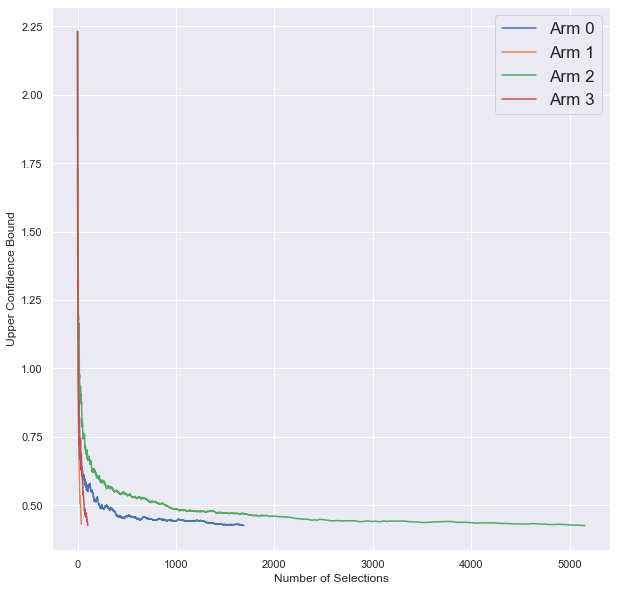

In [66]:
####### Don't use this function for very high values of K 
plot_upper_confidence_bounds_decrease(upper_confidence_bounds, figsize = (10, 10))

All UCB curves stop except one because at some point the algorithm stops gathering data about suboptimal arms since it identified the empiricaly best arm.

<h3> Regret vs Probability Error $\delta$ </h3>

In [67]:
number_of_rounds = 10000
number_of_arms = 4
click_through_rates = generate_bernouilli_variables(number_of_arms)

In [68]:
click_through_rates

array([0.22420477, 0.23305684, 0.31992307, 0.22281532])

In [69]:
dataset = generate_bernoulli_simulation(number_of_rounds,click_through_rates)

The <b> <i> plot_regret_versus_UCB_probability_error </i> </b> takes, in addition to UCB's inputs, a list of $\delta$ values, it runs UCB for each value of $\delta$ then computes the regret, then it plots all the calculated regrets after running UCBs vs $\delta$ 

In [70]:
probability_errors = np.linspace(0.3, 0.9, 25)

If the function runs for too long, reduce the number of rounds when generating the dataset or reduce the number of probability errors you test

<ipython-input-26-6793a3cc9073>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return rewards, selected_arms, np.array(upper_confidence_bounds)


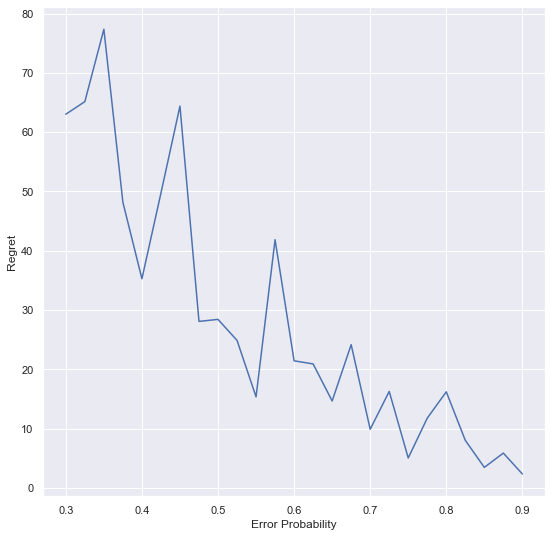

In [71]:
plot_regret_versus_UCB_probability_error(
    dataset, click_through_rates, probability_errors
)

We forced the click-through-rate values to be very far apart then ran the UCB and we can see that choosing a higher value of $\delta$ decrease the regret. Indeed, the goal the UCB algorithm is to converge towards the real value of the CTR by building a confidence interval around it. This can only work if the confidence interval conntains the mean we are trying to converge towards. Our hyperparameter $\delta$'s goal is to quantify the probability of our confidence interval missing the mean. Low values of $\delta$ means we take extra-caution by increasing the size of the interval and make it decrease slowly. This also helps us making sure that we converge towards the right arm if their means are very close. <b> This extra effort is not useful if the arms are very easy to differentiate. </b> By having a high value of $\delta$ we explore much less because the intervals decrease much faster because we care less about containing the mean. And this works in a setting where <b> careful exploration is not needed to find the best arm, since this best arm far outclasses all the others </b>

<h3> UCB Weakness : High number of arms </h3>

We will be dealing with of the limitations of UCB : when the number of arms becomes too high.

Given a Bernoulli data simulation, the worst possible strategy is to constantly choose the worst arm (which means the arm with the lowest average reward). The regret of this strategy constitues an upper bound for the data simulation (and this upper bound cannot be higher than the theoretical upper bound we have proven in the course)

The following function <b> <i> compute_instance_worst_possible_regret </i> </b> calculates the regret associated to the worst possible strategy given a Bernoulli data simulation

In [37]:
compute_instance_worst_possible_regret(number_of_rounds, list(click_through_rates))

3847.0346258971013

While the <b> <i> compute_strategy_regret </i> </b> function calculates the regret of the algorithm that ran with the imput Bernoulli data simulation

We compute the UCB's regret in an instance with a high number of arms $K$ and compare it to the worst case regret.

In [38]:
number_of_rounds = 10000
number_of_arms = 100
click_through_rates = generate_bernouilli_variables(number_of_arms)

In [39]:
dataset = generate_bernoulli_simulation(number_of_rounds,click_through_rates)

In [40]:
ucb_rewards, ucb_selected_arms, upper_confidence_bounds = UCB_sub_gaussian(dataset.values, 0.05)

<ipython-input-26-6793a3cc9073>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return rewards, selected_arms, np.array(upper_confidence_bounds)


In [41]:
ucb_regret = compute_strategy_regret(number_of_rounds, ucb_selected_arms, click_through_rates)
ucb_regret

510.134020716157

In [42]:
instance_worst_regret = compute_instance_worst_possible_regret(number_of_rounds, list(click_through_rates))
instance_worst_regret

619.0191206829036

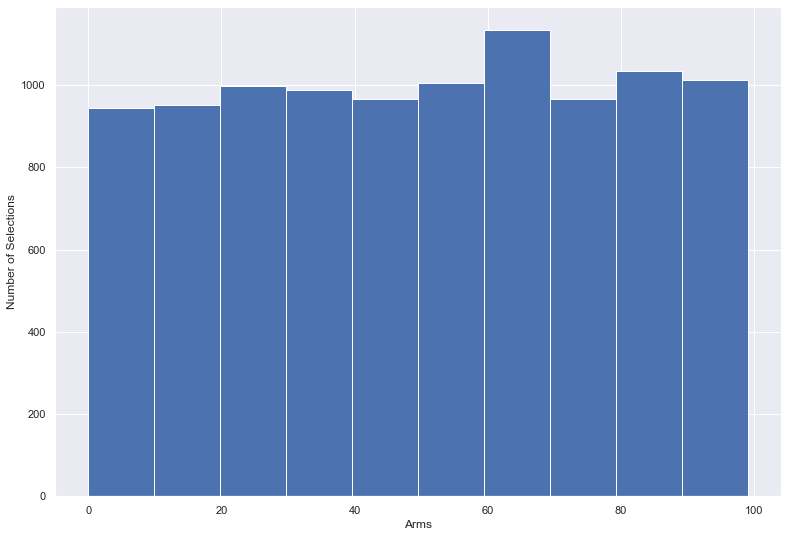

In [43]:
plot_arm_selection_histogram(ucb_selected_arms)

UCB acheives such low performance when K increases. Indeed, UCB works with the concept of optimism in the face of uncertainty. This is nice because it forces the algorithm to explore any arm with few information, but it will also <b> cause the algorithm to be optimistic about arms with a terrible average reward </b>. It will explore such arms less than others, but if you multiply the number of arms, <b> it will have to give them all a try no matter what, which means we need a lot of samples just to gather minimal information about each arm </b> (Running the algorithm with $N = 10 000$ and $K = 100$ barely makes the algorithm start to distinguish the good arms from the bad ones.

<h1> Strategy 4 : Outperforming UCB with Thompson Sampling </h1>

We will : 


*   Talk about a new framework for Bandits : Bayesian Bandits
*   Define some mathematical tools from Bayesian Statistics 
*   Define the Thompson Sampling Algorithm
*   Play around with it's implementation and outperform UCB in our Advertising Use Case





<h3> The Bayesian Bandit Problem </h3>

The setting from the Stochastic Bandit remains the same, we just formulate it in a Bayesian Way. 



*   There are $K$ arms with distributions of average reward $\mu = (\mu_{1},..., \mu_{k})$, all rewards belonging to the interval $[0,1]$

*   The learning algorithm is initially uncertain about the value of $\mu$ (no experience with arms) and <b> represents his uncertainty using an independent prior belief  $\theta = P(\mu) = (\theta_{1},..., \theta_{K})$ </b>

*   During each of the $N$ rounds, <b> we choose the arm $k$ by using the probability distribution  given by the current prior </b> and sample a reward using the likelihood function $P(r_{k} /  k,  \theta) $

*   Given the sampled reward, we <b> readjust what we think the best arm is </b> by computing a posterior probability $p(\mu / r_k, \theta )$ which allows us to readjust our prior vector $\theta$

*   <b> The Objective :</b> With a prior update strategy, find the <b> best prior </b> which gives us the highest probability of sampling the best arm $k^*$ <b> (exploitation) </b>, while still having non-null probabilities for sub-optimal actions <b> (exploration) </b> 







<h3> Small Detour : Undestanding the Beta Distribution </h3>

<b> Beta Law Definition <b>

Understanding the Thompson Sampling algorithm requires understanding the <b> Beta Distribution </b>. Let's talk about it !

When a random variable $X$ follows a Beta law of parameters $(\alpha,\beta)$ it's density function is as follows : 

$P(x) = C x^{\alpha - 1}(1-x^{\beta - 1}) $ where C is a normalisation constant that doesn't matter too much : $C = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}$ which uses the gamma function

Important to know, when $X \sim Beta(\alpha,\beta)$ we have : 


*   $ E(X) = \frac{\alpha}{\alpha + \beta} $ 
*   $ V(X) = \frac{\alpha\beta}{(\alpha + \beta)^{2}(\alpha + \beta + 1)}$



<b> Understanding the $\alpha$ and $\beta$ parameters 

The parameters obviously govern the behavior of the distribution

<b> This is how the parameters influence the distribution </b> : 


*  <b> Increasing $\alpha$ pushes the mass of the distribution to the right </b>
*  <b> Increasing $\beta$ pushes the mass of the distribution to the left </b>
*  <b> The higher the values of $\alpha$ and $\beta$ are, the lower the variance of the distribution is, and the more the data concentrates around the mean </b>




With the code below, you can visualize how the Beta distribution works, you can try out these parameters for example


*   $\alpha = 1$ & $\beta = 1$
*   $\alpha = 1$ & $\beta = 2$
*   $\alpha = 100$ & $\beta = 1$
*   $\alpha = 100$ & $\beta = 100$
*   $\alpha = 2$ & $\beta = 3$








In [72]:
from scipy.stats import beta

C:\Users\lilia\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'a = 100  b = 1')

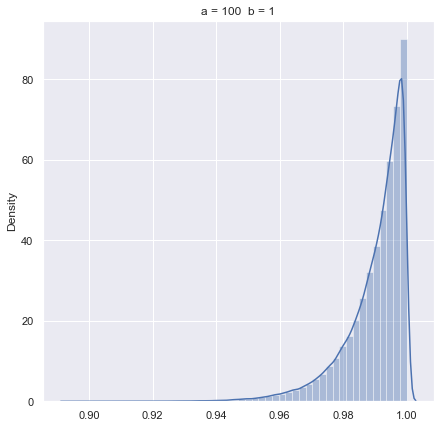

In [73]:
a = 100
b = 1
beta_distribution = beta.rvs(a= a, b = b, size=100000)
plt.figure(figsize=(7,7))
sns.distplot(beta_distribution).set_title("a = " + str(a) + "  b = " + str(b))

<h3> Why does the Beta Distribution matter for us ? </h3>

Thompson Sampling is a Bayesian algorithm.

When using Bayesian Inference, <b> it is usually computationaly heavy to update the prior at each step</b> (it requires computing heavy integrals, or approximating them with Monte Carlo methods)

However, the Beta distribution has a special mathematical property : 

*   If we want to sample from a Bernoulli distribution given a Beta prior, <b> it is guaranteed that our posterior distribution is also Beta distributed </b>

*   This means that <b>updating our prior is as easy as sampling from a Beta distribution </b> , no Monte Carlo, no integrals, <b> no heavy computation </b> 

*   <b> This will allow us to build a fast and efficient Thompson Sampling algorithm for our Advertising Use Case, since we will be using a Beta prior for our Bernoulli Bandits ! </b>





<h3> The Thompson Sampling Algorithm </h3>

<b> Setting </b>

We assume the <b> Bandits are Bernoulli-distributed </b> with unknown average rewards $\mu = (\mu_{1},..., \mu_{k})$

We begin by initializing a <b> Beta-distributed independent prior </b> $\theta$ over $\mu$.

 This means, <b> each arm $k$ has it's associated Beta parameters $\alpha_{k}$ and $\beta_{k}$ </b>

We note $ \alpha = (\alpha_{1},..., \alpha_{K})$ and $ \beta = (\beta_{1},..., \beta_{K})$

<b> Pseudo-Code </b>

For each round $i \in \{1, ..., N$ \} $ : 

*   For each arm $k \in \{1, ..., K$ \}$ :

  *   We sample $\hat{\theta}_{k} \sim  Beta(\alpha_{k},\beta_{k})$ to get our estimated prior probabilites 
  *   We select the arm $t = argmax_{k}(\hat{\theta}_{k})$ and observe the reward $r_{t}$

*   For each arm $k \in \{1, ..., K$ \}$, we update the prior distributions in the following way :

$ (\alpha_{k},\beta_{k}) = \begin{cases} (\alpha_{k},\beta_{k}) & if \ \ k \neq t \\ (\alpha_{k},\beta_{k}) + (r_{t}, 1 - r_{t}) & if \ \ k = t \end{cases} $ 

<b> Convergence & Exploitation-Exploration </b>

Let's take extreme cases to undestand what's going on : 
*   When an Ad gives consistently gives 1 rewards :
  *   Over time we get $\alpha >> \beta$
  *   We also get $ E(prior\_ad) = \frac{\alpha}{\alpha + \beta} 	\approx 1$ 
  *   And $ V(prior\_ad) = \frac{\alpha\beta}{(\alpha + \beta)^{2}(\alpha + \beta + 1)} \approx 0$
  *  <b>  This means that the prior will choose almost always this Ad (Exploitation) </b> 


*   When an Ad gives consistently gives 0 rewards :
  *   Over time we get $\alpha << \beta$
  *   We also get $ E(prior\_ad) \approx 0$ 
  *   And $ V(prior\_ad) \approx 0$
  *  <b>  This means that the prior will almost never choose this Ad (Smart Exploration) </b> 

*   When an Ad gives consistently alternates 0 and 1 rewards :
  *   Over time we get $\alpha = \beta$
  *   We also get $ E(prior\_ad) \approx 0.5$ 
  *  <b>  This means that the prior will be sampled from a distribution centered on 0.5 and shaped similarly to a Gaussian (Continuous Exploration) </b> 







In [74]:
def thompson_sampling(rounds_array, conversion_rates):
    selected_strategies = []
    rewards = [[] for i in range(rounds_array.shape[0])]
    numbers_of_positive_rewards = np.zeros(rounds_array.shape[1])
    numbers_of_null_rewards = np.zeros(rounds_array.shape[1])
    for episode in range(rounds_array.shape[0]):
        best_thompson_sampling_strategy = 0
        highest_beta_draw = 0
        
        # Finding the best strategy according to Thompson Sampling for this round
        ######### Your code goes here !
        ######### Hint : Look at the betavariate function
        
        for arm in range(rounds_array.shape[1]):
            beta_law_draw = betavariate(
                numbers_of_positive_rewards[arm] + 1, numbers_of_null_rewards[arm] + 1
            )
            if beta_law_draw > highest_beta_draw:
                highest_beta_draw = beta_law_draw
                best_thompson_sampling_strategy = arm
        # Updating the number of rewards used to sample from the beta distribution
        selected_strategies.append(best_thompson_sampling_strategy)
        reward = rounds_array[episode, best_thompson_sampling_strategy]
        rewards[best_thompson_sampling_strategy].append(reward)
        if reward == 1:
            numbers_of_positive_rewards[best_thompson_sampling_strategy] += 1
        else:
            numbers_of_null_rewards[best_thompson_sampling_strategy] += 1
    return rewards, selected_strategies

<h3> Thompson Sampling Strategy </h3>

Computing the regret of an instance is good, but since by definition it is a sum, it doesn't tell us about how the regret evolved during the Algorithm's learning process. This is why we are also interessted in <b> immediate regret </b> which is the regret you get at <b>each round </b> while running the algorithm

The <b> <i> compute_immediate_regrets </i> </b> function calculates the immediate regret of each round that the algorithm went through during the learning process.

The <b> <i> plot_immediate_regrets </i> </b> function allows us to plot the evolution of immediate regret and assess if an algorithm is really converging towards small regrets (ideally close to 0) or not. 

In [82]:
number_of_rounds = 7000
number_of_arms = 15
click_through_rates = generate_bernouilli_variables(number_of_arms)

In [83]:
dataset = generate_bernoulli_simulation(number_of_rounds,click_through_rates)

In [84]:
thompson_rewards, thompson_selected_arms = thompson_sampling(dataset.values, click_through_rates)

In [85]:
thompson_regret = compute_strategy_regret(number_of_rounds, thompson_selected_arms, click_through_rates)

In [86]:
thompson_immediate_regrets = compute_immediate_regrets(thompson_rewards, max(click_through_rates))

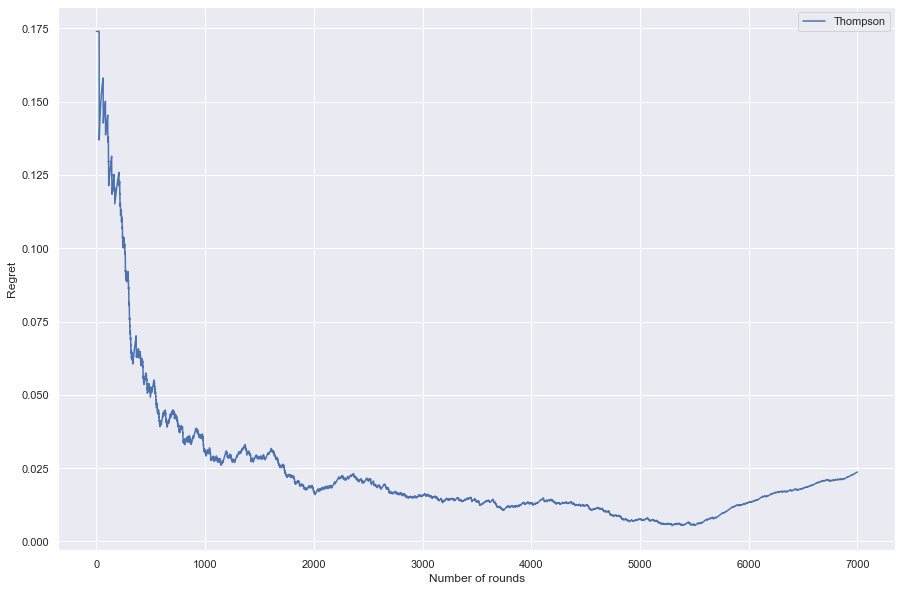

In [87]:
plot_immediate_regrets([thompson_immediate_regrets],
                       labels = ['Thompson'])

Thompson Sampling's regret is random at first. Indeed, as a Bayesian algorithm, initializing the priors of the Beta distribution is very important. Assuming we have no knowledge about the arms, choosing a uniform distribution of prior probabilities seems natural. But because this doesn't represent reality, performance will fluctuate a lot at the beginning since we are giving more probabilities to sub-optimal arms than they should. This is especially true if the gap between the arms' mean rewards is high.

<h3> Thompson Sampling VS UCB </h3>

We will run the UCB algorithm against the same instances as the Thompson Sampling algorithm and compare them in terms of regret and immediate regret evolution.

In [88]:
number_of_rounds = 10000
number_of_arms = 150
click_through_rates = generate_bernouilli_variables(number_of_arms)

In [89]:
dataset = generate_bernoulli_simulation(number_of_rounds,click_through_rates)

In [90]:
ucb_rewards, ucb_selected_arms, upper_confidence_bounds = UCB_sub_gaussian(dataset.values, 0.05)

<ipython-input-26-6793a3cc9073>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return rewards, selected_arms, np.array(upper_confidence_bounds)


In [91]:
thompson_rewards, thompson_selected_arms = thompson_sampling(dataset.values, click_through_rates)

In [92]:
ucb_regret = compute_strategy_regret(number_of_rounds, ucb_selected_arms, click_through_rates)
thompson_regret = compute_strategy_regret(number_of_rounds, thompson_selected_arms, click_through_rates)
instance_worst_regret = compute_instance_worst_possible_regret(number_of_rounds, list(click_through_rates))

print ("UCB Regret : ", ucb_regret)
print ("Thompson Regret : ", thompson_regret)
print ("Instance Worst Case Regret : ", instance_worst_regret)

UCB Regret :  280.3397076261683
Thompson Regret :  274.1018888784005
Instance Worst Case Regret :  349.8644297563925


You can give the <b> <i> plot_immediate_regrets </i> </b> function a list of lists of immediate regrets from different strategies to compare different algorithms.

In [93]:
thompson_immediate_regrets = compute_immediate_regrets(thompson_rewards, max(click_through_rates))
ucb_immediate_regrets = compute_immediate_regrets(ucb_rewards, max(click_through_rates))

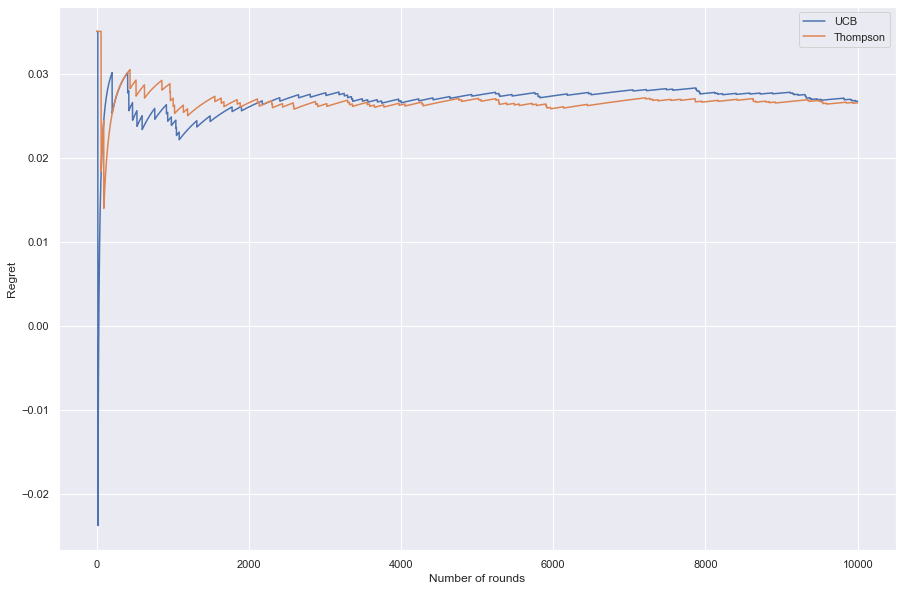

In [94]:
plot_immediate_regrets([ucb_immediate_regrets, thompson_immediate_regrets],
                       labels = ['UCB', 'Thompson'])

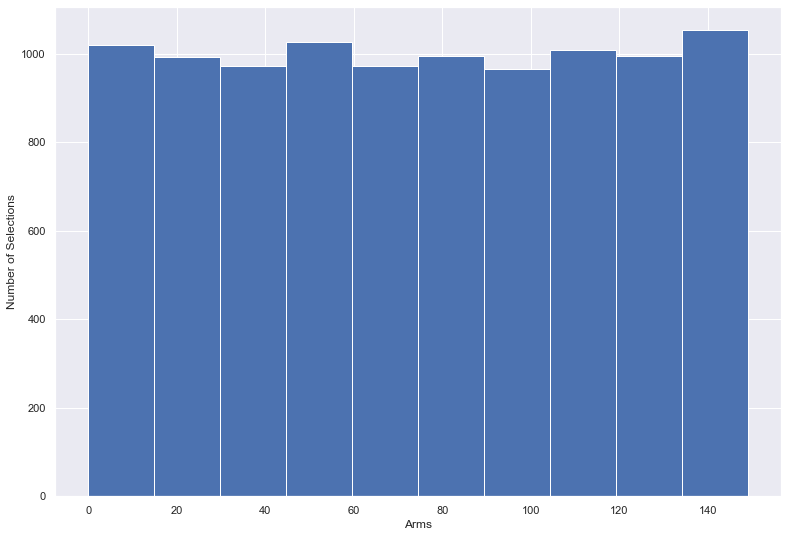

In [95]:
plot_arm_selection_histogram(ucb_selected_arms)

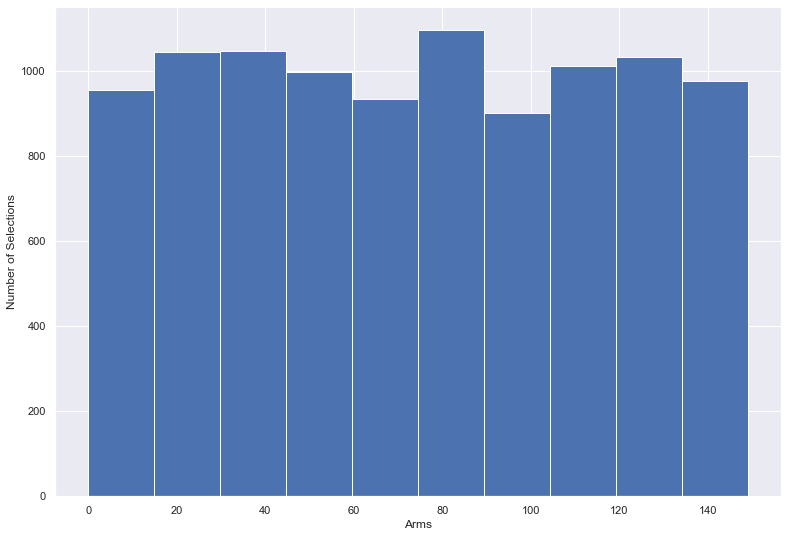

In [96]:
plot_arm_selection_histogram(thompson_selected_arms)

We can see that Thompson Sampling outperforms UCB in most generated instances, especially with high values of $K$ (Thompson Sampling with high values of $K$ can be very slow). Indeed, we have already established that UCB suffers from high regret when the number of arms $K$ is high. Thompson Sampling is by nature more "greedy" than the UCB because it never really treats arms with little information equally like the UCB does. We can't reasonably expect the priors to be updated for each and every single sub-optimal arm while having converging at the same time towards the best arm. So Thompson Sampling will usually explore less than UCB but will still explore enough because of it's probabilistic nature and will still explore better than $\epsilon$-greedy because it ranks sub-optimal arms by assigning probabilities to them

We noticed that Thompson Sampling is slower than UCB. We can get Thompson Sampling faster. Indeed, another problem with UCB is that it can't converge without updating the confidence interval of an arm each time it is played. Whereas in Thompson Sampling, we can allow ourselves to skip prior updates to reduce computation time. For example, we can choose to update the priors only after a batch of 5 observations arrives. Regret doesn't increase too much with such a strategy if our number of rounds is high enough and it allows a faster implementation

<h1> Strategy 5 : Testing EXP3

### Adversarial Bandits

Let k > 1 be the number of arms. A k-armed
adversarial bandit is an arbitrary sequence of
reward vectors $(x_{t})$, where $ xt ∈ [0, 1]^k$
. In each
round, the learner chooses a distribution over the
actions $P_{t} ∈ P_{k−1}$. Then the action $At ∈ [k]$ is
sampled from $P_{t}$, and the learner receives reward
$x_{tAt}$.

### The EXP3 algorithm

The simplest algorithm for adversarial bandits is called Exp3, which stands
for ‘exponential-weight algorithm for exploration and exploitation’.



Input : $ n, k, \gamma $

*   Set $ \hat{S_{0i}} = 0 $ for all $i$ 

*   For $i \in \{1, ..., n \}$ :

  *   Calculate the sampling distribution $P_{t}$: $P_{ti} = \frac{exp(\gamma\hat{S_{t-1,i}})}{\sum exp(\gamma\hat{S_{t-1,j}})}$
  *   Sample $A_{t} ∼ P_{t}$ and observe reward $r_{t}$
  *   Calculate $ \hat{S_{t,i}} $: $ \hat{S_{t,i}} = \hat{S_{t-1,i}} + 1 - \frac{ \mathbb{1} (A_{t}=i) (1-r_{t})}{P_{ti}} $


In [97]:
# Normalize a list of floats to a probability distribution.  Gamma is an
# egalitarianism factor, which tempers the distribtuion toward being uniform as
# it grows from zero to one.
def distr(weights, gamma=0.0):
    theSum = float(sum(weights))
    return tuple((1.0 - gamma) * (w / theSum) + (gamma / len(weights)) for w in weights)


In [98]:
# Pick an index from the given list of floats proportionally
# to the size of the entry (i.e. normalize to a probability
# distribution and draw according to the probabilities).
def draw(weights):
    choice = np.random.uniform(0, sum(weights))
    choiceIndex = 0

    for weight in weights:
        choice -= weight
        if choice <= 0:
            return choiceIndex

        choiceIndex += 1

In [99]:
def exp3(rounds_array, gamma):
    
    selected_arms = []
    rewards = [[] for i in range(rounds_array.shape[1])]
    number_of_arms = rounds_array.shape[1]
    rewardMin = 0
    rewardMax = 1
    weights = [1.0] * number_of_arms

    for episode in range(rounds_array.shape[0]):
        probabilityDistribution = distr(weights, gamma)
        selected_arm = draw(probabilityDistribution)
        selected_arms.append(selected_arm)
        episode_reward = rounds_array[episode][selected_arm]
        scaledReward = (episode_reward - rewardMin) / (rewardMax - rewardMin) # rewards scaled to 0,1

        estimatedReward = 1.0 * scaledReward / probabilityDistribution[selected_arm]
        weights[selected_arm] *= math.exp(estimatedReward * gamma / number_of_arms) # important that we use estimated reward here!
        rewards[selected_arm].append(episode_reward)

    return rewards, selected_arms, weights

<h3> EXP3 Strategy </h3>

You can now test the EXP3 algorithm given previously and test different parameters of $\gamma$.

In [100]:
number_of_rounds = 10000
number_of_arms = 150
click_through_rates = generate_bernouilli_variables(number_of_arms)
gammas = [0.01,0.1,0.2,0.5,0.8]

In [101]:
dataset = generate_bernoulli_simulation(number_of_rounds,click_through_rates)

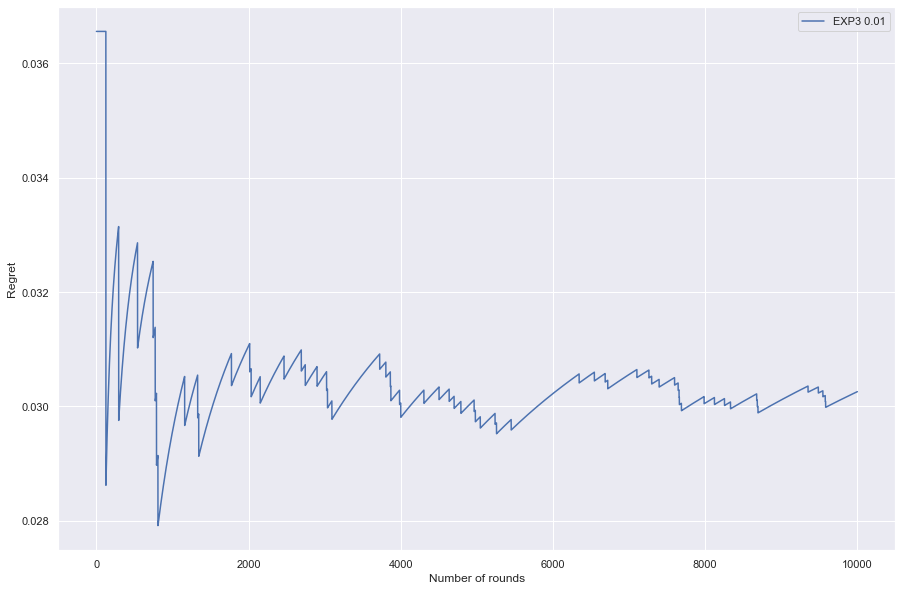

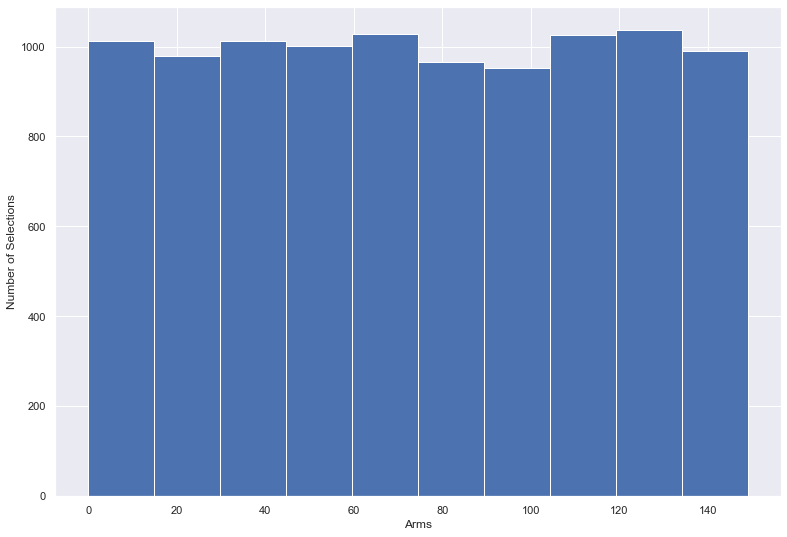

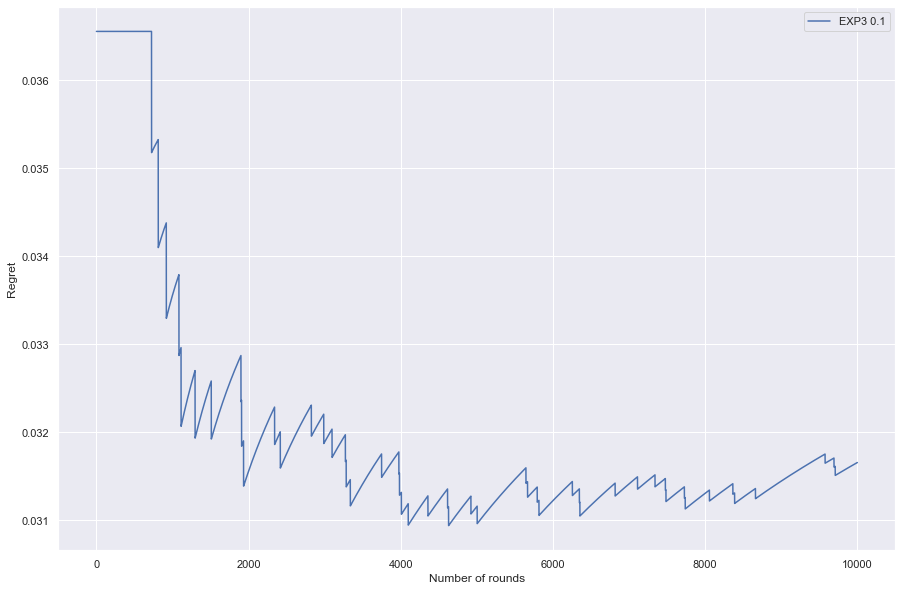

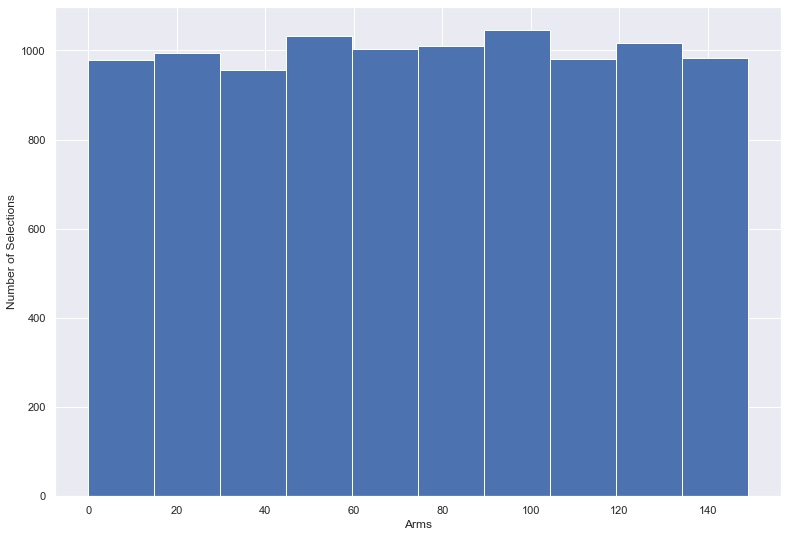

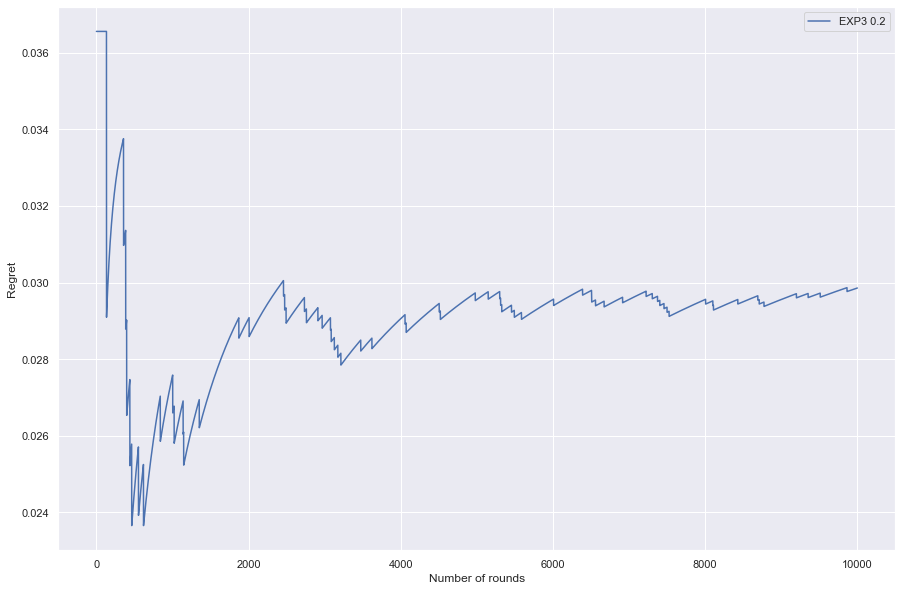

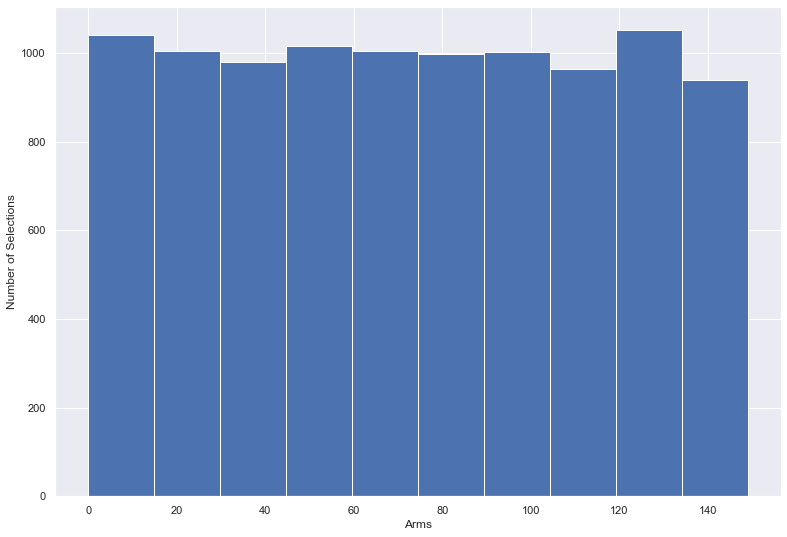

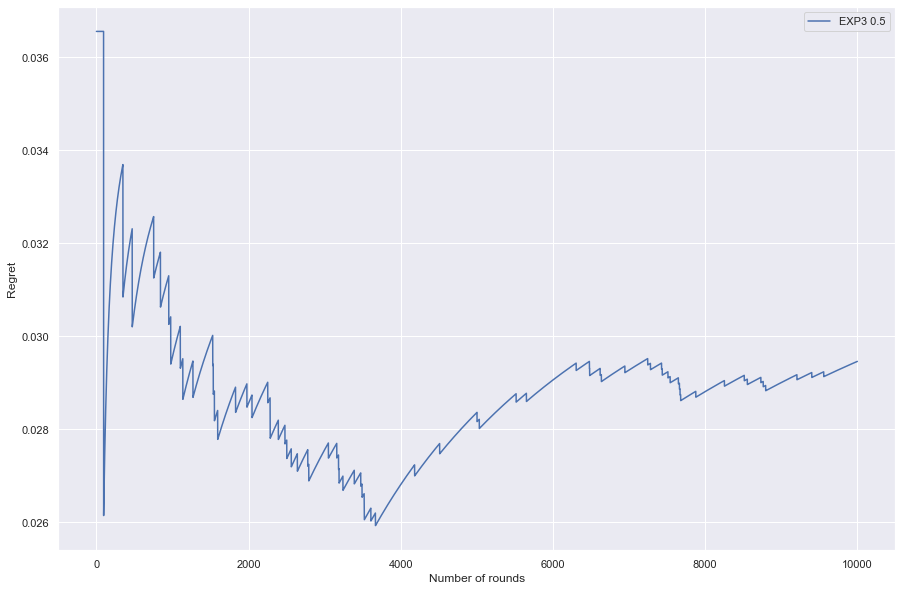

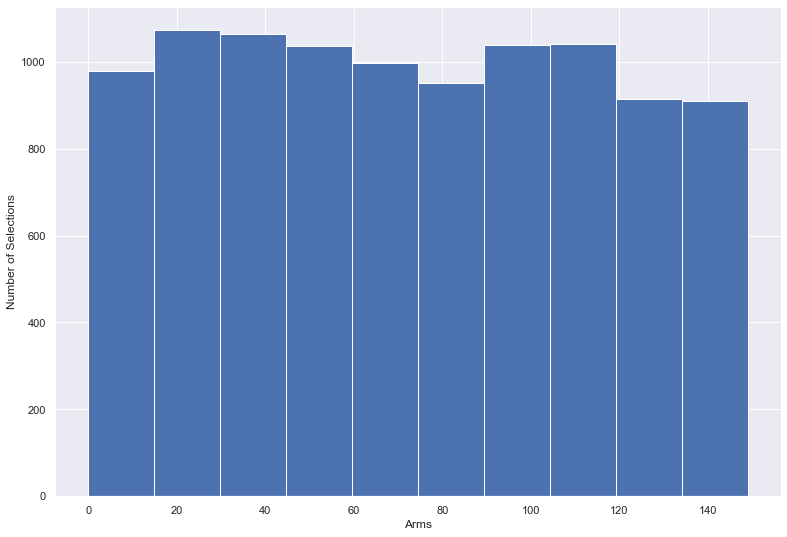

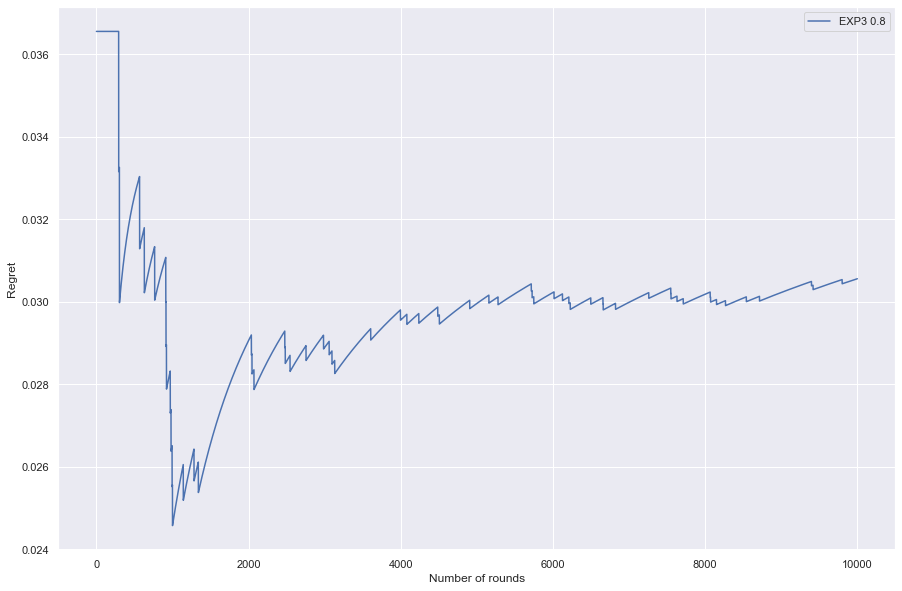

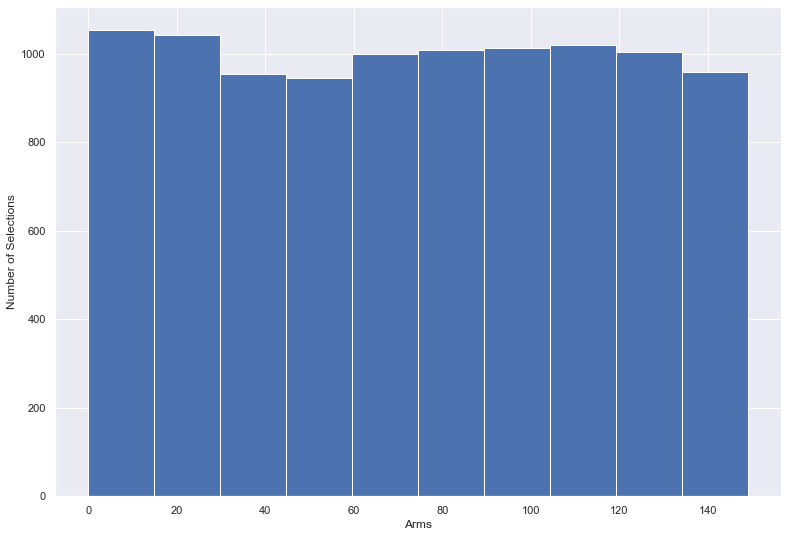

In [102]:
for gamma in gammas:
  exp3_rewards, exp3_selected_arms, weights = exp3(dataset.values, gamma)
  exp3_regret = compute_strategy_regret(number_of_rounds, exp3_selected_arms, click_through_rates)
  exp3_immediate_regrets = compute_immediate_regrets(exp3_rewards, max(click_through_rates))
  plot_immediate_regrets([exp3_immediate_regrets],
                       labels = ['EXP3 '+str(gamma)])
  plot_arm_selection_histogram(exp3_selected_arms)

In [103]:
gamma = 0.8

In [104]:
exp3_rewards, exp3_selected_arms, weights = exp3(dataset.values, gamma)
exp3_regret = compute_strategy_regret(number_of_rounds, exp3_selected_arms, click_through_rates)
exp3_immediate_regrets = compute_immediate_regrets(exp3_rewards, max(click_through_rates))

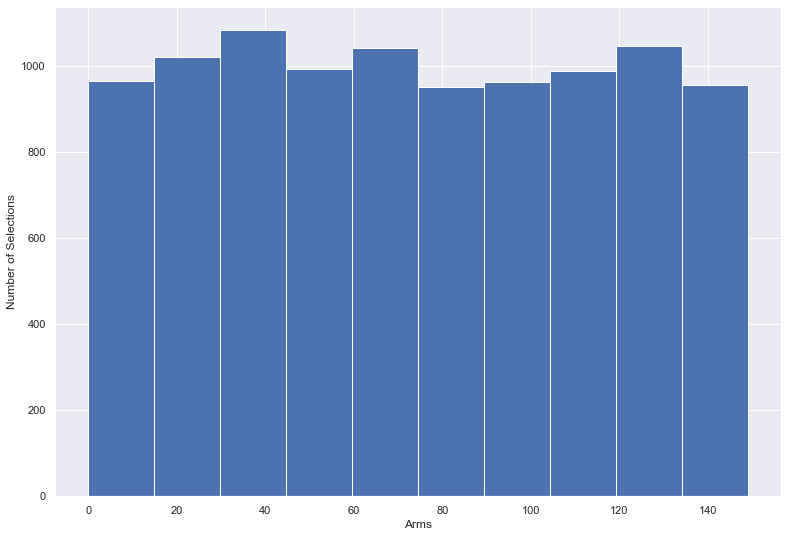

In [105]:
plot_arm_selection_histogram(exp3_selected_arms)

The parameter $\gamma$ is called the learning rate. When the learning rate is large, $P_{t}$
concentrates about the arm with the largest estimated reward and the resulting
algorithm exploits aggressively. For small learning rates, $P_{t}$ is more uniform,
and the algorithm explores more frequently. Note that as $P_{t}$ concentrates, the
variance of the importance-weighted estimators for poorly performing arms
increases dramatically. There are many ways to tune the learning rate, including
allowing it to vary with time.

<h3> EXP3 VS Thompson Sampling & UCB </h3>

Here, we run the 3 algorithms to compare it. 

In [110]:
ucb_rewards, ucb_selected_arms, upper_confidence_bounds = UCB_sub_gaussian(dataset.values, 0.05)

<ipython-input-26-6793a3cc9073>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return rewards, selected_arms, np.array(upper_confidence_bounds)


In [111]:
thompson_rewards, thompson_selected_arms = thompson_sampling(dataset.values, click_through_rates)

In [112]:
thompson_immediate_regrets = compute_immediate_regrets(thompson_rewards, max(click_through_rates))
ucb_immediate_regrets = compute_immediate_regrets(ucb_rewards, max(click_through_rates))

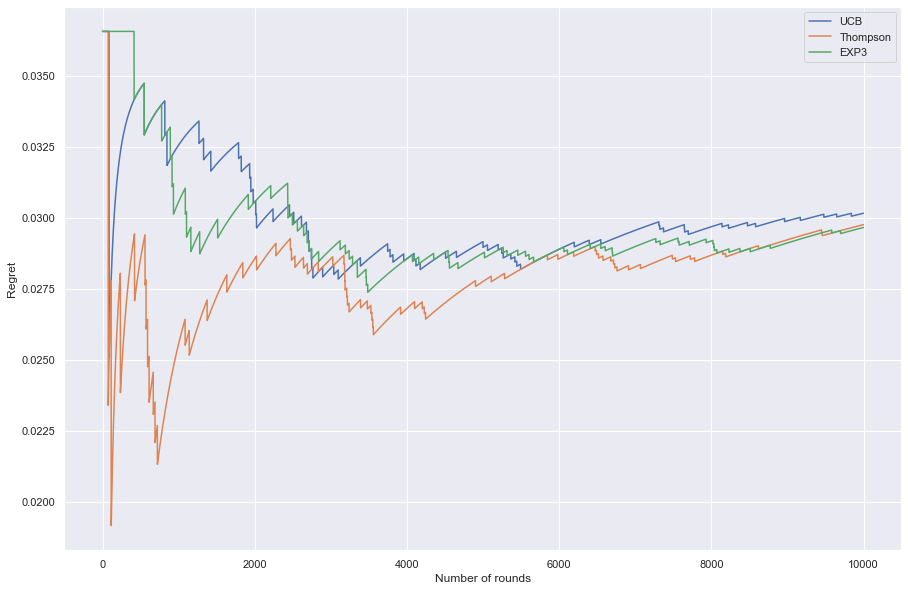

In [113]:
plot_immediate_regrets([ucb_immediate_regrets, thompson_immediate_regrets, exp3_immediate_regrets],
                       labels = ['UCB', 'Thompson', 'EXP3'])